### Investigate 749 to 750 null dates
   - in
      - student_start_datetime
      - student_stop_datetime
      - was_fully_scored_datetime

In [29]:
%run '../lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [30]:
dfFlt  = load_df('dfFlt')

###### Create dataframe of null dates

In [24]:
nullDf = dfFlt.filter(F.col('student_start_datetime').isNull())

nullDf.count()

749

###### Display single values

In [25]:
display_single_val(nullDf)

,0
ced_assignment_type_code,assessment
is_affecting_grade,True
assignment_max_attempts,1
assignment_late_submission,False
assignment_attempt_number,1
was_fully_scored_datetime,NaT
was_submitted_datetime_actual,NaT
was_in_progress_datetime,NaT
is_force_scored,False
is_manual_scoring_required,False


- Null dates
  - student_start_datetime
  - student_stop_datetime
  - was_fully_scored_datetime
- Also null
  - was_submitted_datetime_actual
  - was_in_progress_datetime
- All dates from Assignment Attempt category
  - Missing 1, scored_datetime
- All from org (360421)
- ced_assignment_type_code = assessment
  - A majority (76,172) of data is this code

###### Display date ranges

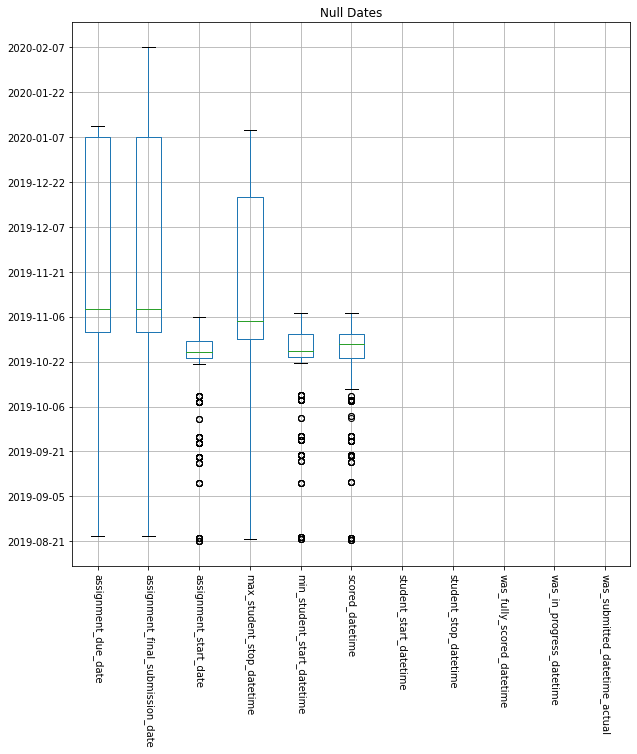

In [27]:
date_boxplot(nullDf, "Null Dates")

- assignment_start_date, min_student_start_datetime & scored_datetime
  - 10/2019 to 11/2019 (with outliers)
- Appears to be for a limited date range and one org
- Will impute missing values with mean

In [46]:
pdDf = get_random_sample(dfFlt).select('student_start_datetime', 'student_stop_datetime', 'was_fully_scored_datetime', 'scored_datetime').toPandas()

In [52]:
# Calculate mean difference in minutes
mStStartDate = ( (pdDf['scored_datetime'] - pdDf['student_start_datetime'])     / np.timedelta64(1, 's') ).mean()
mStStopDate  = ( (pdDf['scored_datetime'] - pdDf['student_stop_datetime'])      / np.timedelta64(1, 's') ).mean()
mWFullScored = ( (pdDf['scored_datetime'] - pdDf['was_fully_scored_datetime'])  / np.timedelta64(1, 's') ).mean()

In [57]:
dfImpute = nullDf.withColumn(
                "student_start_datetime",
                F.when(
                    F.col("student_start_datetime").isNull(),
                    (F.unix_timestamp("scored_datetime") - mStStartDate).cast('timestamp')
                ).otherwise( F.col("student_start_datetime") )
            ).withColumn(
                "student_stop_datetime",
                F.when(
                    F.col("student_stop_datetime").isNull(),
                    (F.unix_timestamp("scored_datetime") - mStStopDate).cast('timestamp')
                ).otherwise( F.col("student_stop_datetime") )
            ).withColumn(
                "was_fully_scored_datetime",
                F.when(
                    F.col("was_fully_scored_datetime").isNull(),
                    (F.unix_timestamp("scored_datetime") - mWFullScored).cast('timestamp')
                ).otherwise( F.col("was_fully_scored_datetime") )
            )

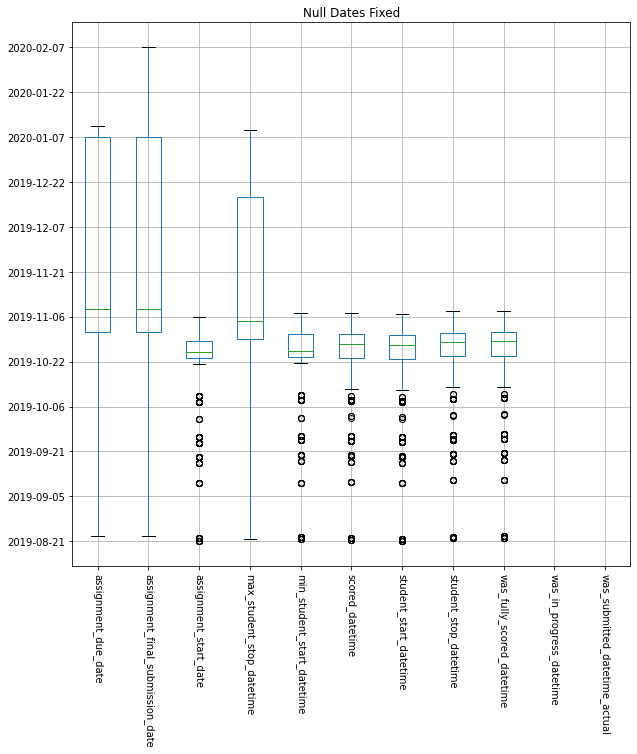

In [58]:
date_boxplot(dfImpute, "Null Dates Fixed")

- student_start_datetime    = scored_datetime + mean(assignment_start_date - scored_datetime)
- student_stop_datetime     = scored_datetime + mean(student_stop_datetime - scored_datetime)
- was_fully_scored_datetime = scored_datetime + mean(was_fully_scored_datetime - scored_datetime)


finish_todo('Investigate 749 t0 750 null dates')